In [44]:
import matplotlib

class mplDeprecation(UserWarning):
    pass

matplotlib.cbook.mplDeprecation = mplDeprecation

import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import fill
import numpy as np
import pandas as pd
import scanpy.external as sce
import scanpy as sc
import scvelo as scv
import gget

# local imports
import utils as ut
import plotting as plt2

sc.settings.verbosity = 3 

In [2]:
"""LOAD EXPRESSION"""
fpath = "/scratch/indikar_root/indikar1/shared_data/sc_HSC/scanpy/analysis.anndata.h5ad"
raw_adata = scv.read(fpath)
raw_adata.layers['log_norm'] = raw_adata.X.copy()

raw_adata = raw_adata[raw_adata.obs['cluster_str'] != 'C6', :].copy() # drop C6
sc.logging.print_memory_usage()
print(raw_adata)
print()

"""LOAD LOOM (VELOCITY)"""
fpath = "/scratch/indikar_root/indikar1/shared_data/sc_HSC/velocyto/merged_UYZEU.loom"
ldata = scv.read(fpath)
sc.logging.print_memory_usage()
ldata

Memory usage: current 6.55 GB, difference +6.55 GB
AnnData object with n_obs × n_vars = 8436 × 15065
    obs: 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'EC_score', 'EB_score', 'FB_score', 'HSC_score', 'MK_score', 'new_cluster', 'cluster_str'
    var: 'gene_name', 'Chromosome', 'Start', 'End', 'Strand', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'ensembl_id', 'tf', 'bj', 'hsc', 'EC', 'EB', 'FB', 'HSC', 'MK', 'cluster_genes'
    uns: 'HSC_vs_FB', 'HSC_vs_FB_pure', 'clusters', 'deg', 'fb_vs_hsc_up', 'go_annotations', 'hsc_v_fib_up', 'hvg', 'log1p', 'neighbors', 'new_cluster', 'new_cluster_colors', 'panglaodb', 'pca', 'scenic_transcription_factors', 'scrublet', 'tabula_sapiens_deg', 'umap', 'v5_tags'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'filtered_counts', 'raw_counts', 'log_norm'


AnnData object with n_obs × n_vars = 13823 × 61860
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

# Filter Loom

In [3]:
# sett up obs
obs = pd.DataFrame({
    'sv_cell_id' : ldata.obs_names,
})

obs['cell_id'] = obs['sv_cell_id'].apply(lambda x : x.split(":")[1][:-1])
obs = obs.set_index('cell_id')

ldata.obs = obs.copy()
ldata.obs_names[:5]

# perform filtering
ldata = ldata[ldata.obs.index.isin(raw_adata.obs_names), :].copy()
ldata

AnnData object with n_obs × n_vars = 8436 × 61860
    obs: 'sv_cell_id'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

# Merge Data

In [4]:
adata = scv.utils.merge(raw_adata, ldata)
adata

AnnData object with n_obs × n_vars = 8436 × 15065
    obs: 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'EC_score', 'EB_score', 'FB_score', 'HSC_score', 'MK_score', 'new_cluster', 'cluster_str', 'sv_cell_id', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size'
    var: 'gene_name', 'Chromosome', 'Start', 'End', 'Strand', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'ensembl_id', 'tf', 'bj', 'hsc', 'EC', 'EB', 'FB', 'HSC', 'MK', 'cluster_genes', 'Accession'
    uns: 'HSC_vs_FB', 'HSC_vs_FB_pure', 'clusters', 'deg', 'fb_vs_hsc_up', 'go_annotations', 'hsc_v_fib_up', 'hvg', 'log1p', 'neighbors', 'new_cluster', 'new_cluster_colors', 'panglaodb', 'pca', 'scenic_transcription_factors', 'scrublet', 'tabula_sapiens_deg', 'umap', 'v5_tags'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'f

# Filtering

In [5]:
sc.pp.filter_cells(adata, min_genes=500)
sc.pp.filter_genes(adata, min_cells=5)

n_genes = 6000

sc.pp.highly_variable_genes(
    adata,
    n_top_genes=n_genes,
    subset=True,
)

adata

filtered out 113 cells that have less than 500 genes expressed
filtered out 497 genes that are detected in less than 5 cells
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


AnnData object with n_obs × n_vars = 8323 × 6000
    obs: 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'EC_score', 'EB_score', 'FB_score', 'HSC_score', 'MK_score', 'new_cluster', 'cluster_str', 'sv_cell_id', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size'
    var: 'gene_name', 'Chromosome', 'Start', 'End', 'Strand', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'ensembl_id', 'tf', 'bj', 'hsc', 'EC', 'EB', 'FB', 'HSC', 'MK', 'cluster_genes', 'Accession'
    uns: 'HSC_vs_FB', 'HSC_vs_FB_pure', 'clusters', 'deg', 'fb_vs_hsc_up', 'go_annotations', 'hsc_v_fib_up', 'hvg', 'log1p', 'neighbors', 'new_cluster', 'new_cluster_colors', 'panglaodb', 'pca', 'scenic_transcription_factors', 'scrublet', 'tabula_sapiens_deg', 'umap', 'v5_tags'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'fi

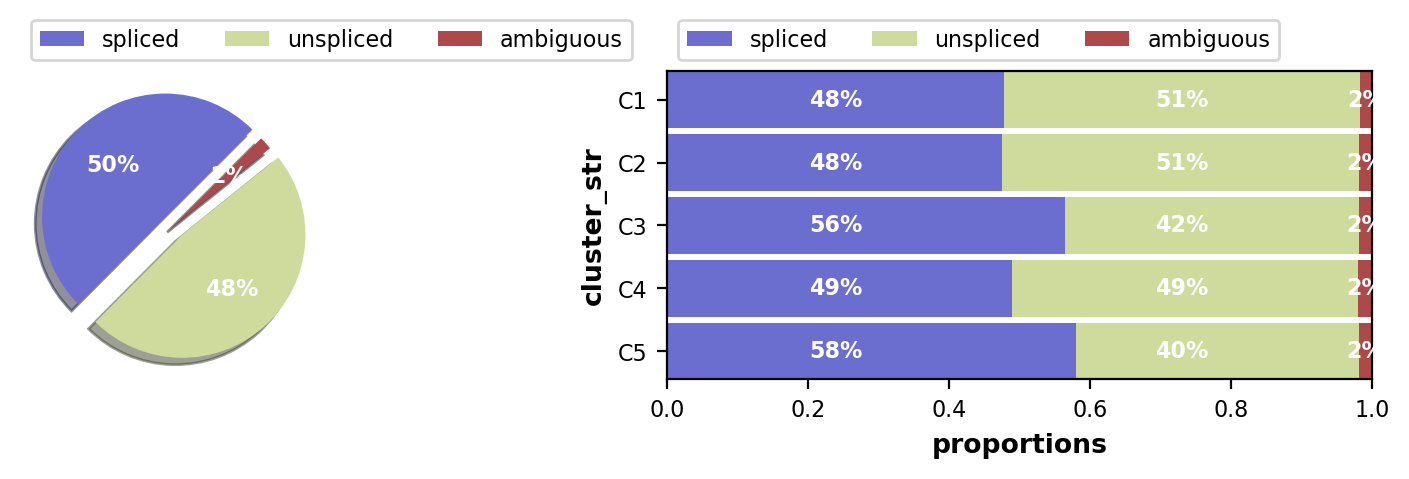

In [6]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 7, 5

scv.pl.proportions(adata, groupby='cluster_str', dpi=200)

# Preprocessing

computing PCA
    with n_comps=50
    finished (0:00:08)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:23)


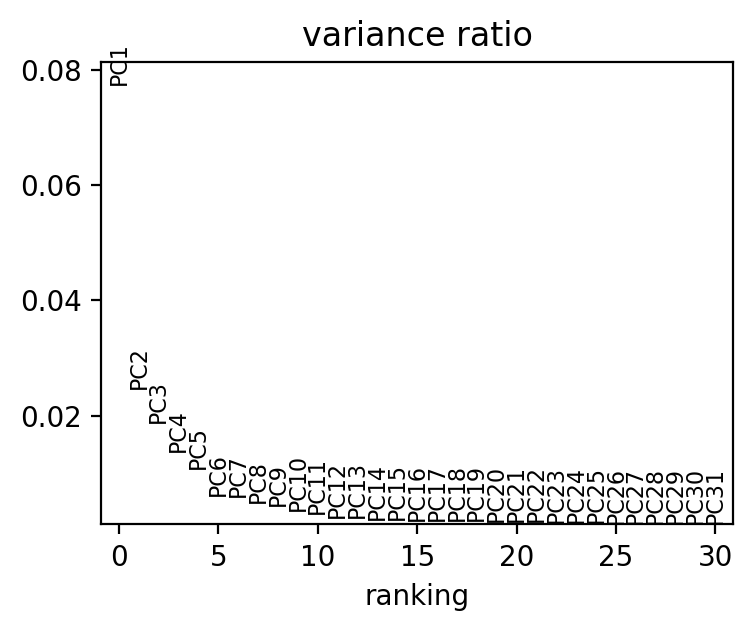

In [7]:
sc.pp.pca(adata)
sc.pp.neighbors(
    adata, 
    n_neighbors=15,
)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 3

sc.pl.pca_variance_ratio(adata)

# scVelo

In [8]:
scv.pp.filter_and_normalize(adata)

scv.pp.moments(
    adata,
    n_pcs=20,
    n_neighbors=5,
)

adata

Normalized count data: spliced, unspliced.
Logarithmized X.
computing moments based on connectivities


/home/cstansbu/.local/lib/python3.12/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)


    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


AnnData object with n_obs × n_vars = 8323 × 6000
    obs: 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'EC_score', 'EB_score', 'FB_score', 'HSC_score', 'MK_score', 'new_cluster', 'cluster_str', 'sv_cell_id', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts'
    var: 'gene_name', 'Chromosome', 'Start', 'End', 'Strand', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'ensembl_id', 'tf', 'bj', 'hsc', 'EC', 'EB', 'FB', 'HSC', 'MK', 'cluster_genes', 'Accession'
    uns: 'HSC_vs_FB', 'HSC_vs_FB_pure', 'clusters', 'deg', 'fb_vs_hsc_up', 'go_annotations', 'hsc_v_fib_up', 'hvg', 'log1p', 'neighbors', 'new_cluster', 'new_cluster_colors', 'panglaodb', 'pca', 'scenic_transcription_factors', 'scrublet', 'tabula_sapiens_deg', 'umap', 'v5_tags'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
   

In [9]:
scv.tl.recover_dynamics(adata)

scv.tl.velocity(
    adata,
    mode='dynamical',
)

scv.tl.velocity_graph(
    adata, 
    n_jobs=1,
    n_neighbors=15,
    
)

recovering dynamics (using 1/36 cores)


  0%|          | 0/186 [00:00<?, ?gene/s]

/home/cstansbu/miniconda3/envs/scanpy/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=585046) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


    finished (0:02:33) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:02) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/36 cores)


  0%|          | 0/8323 [00:00<?, ?cells/s]

/home/cstansbu/miniconda3/envs/scanpy/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=585046) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


    finished (0:00:03) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


# Plotting

computing velocity embedding
    finished (0:00:01) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


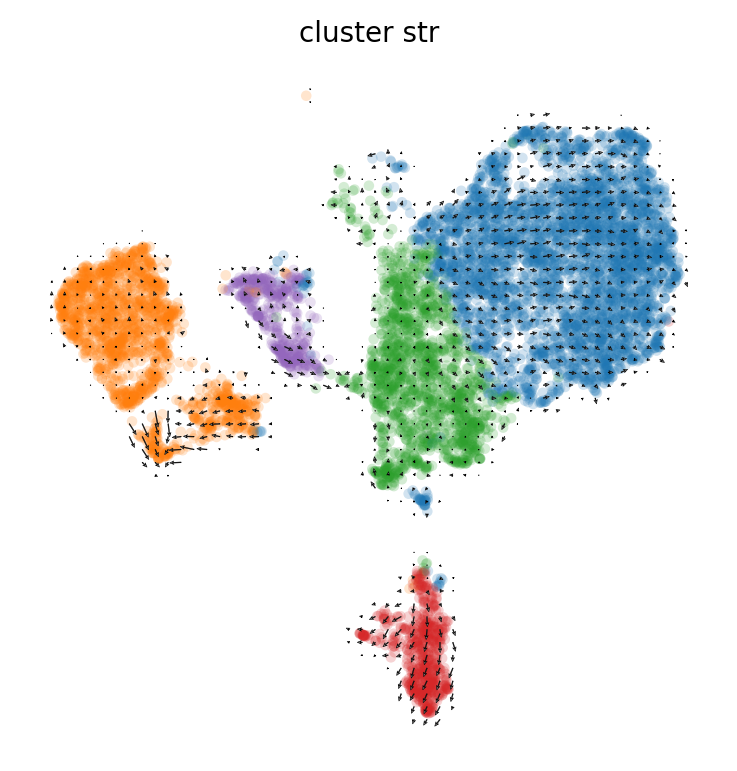

In [10]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4.5, 4.5

scv.pl.velocity_embedding_grid(
    adata, 
    basis='umap',
    color='cluster_str',
)

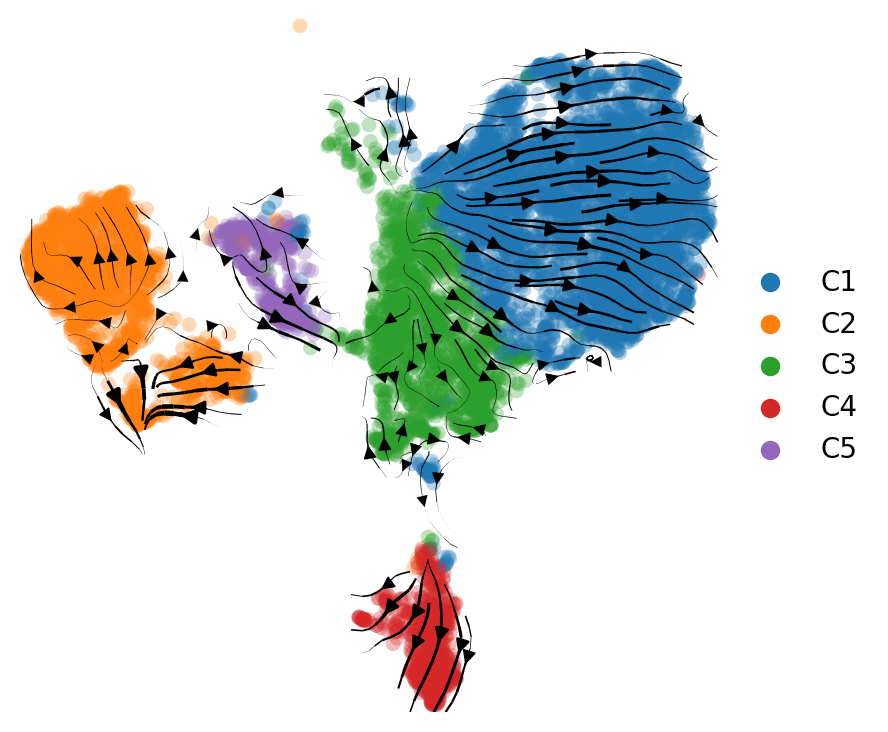

In [11]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4.5, 4.5

scv.pl.velocity_embedding_stream(
    adata, 
    basis='umap',
    color='cluster_str',
    title="",
    legend_loc='right_margin',
)

computing terminal states
    identified 10 regions of root cells and 4 regions of end points .
    finished (0:00:05) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


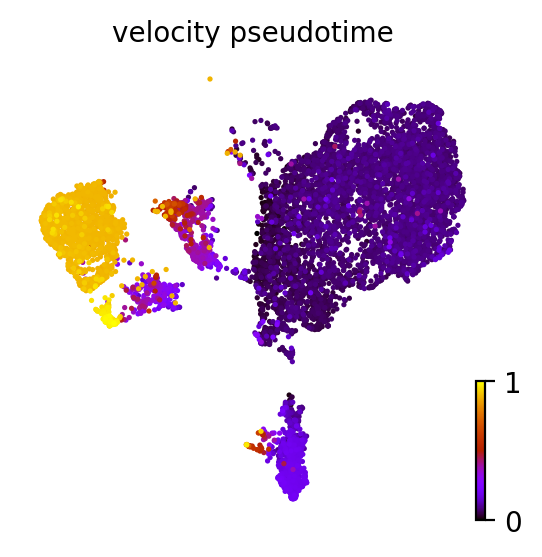

In [12]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 3

scv.tl.velocity_pseudotime(
    adata,
)

scv.pl.scatter(
    adata, 
    color='velocity_pseudotime', 
    cmap='gnuplot',
)

Text(0.5, 0, '')

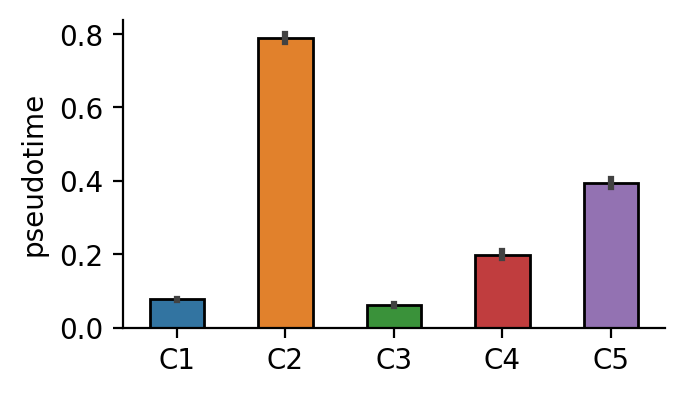

In [13]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3.5, 2

sns.barplot(
    data=adata.obs,
    x='cluster_str',
    y='velocity_pseudotime',
    hue='cluster_str',
    width=0.5,
    ec='k',
)

sns.despine()

plt.ylabel('pseudotime')
plt.xlabel('')

computing latent time using root_cells as prior
    finished (0:00:03) --> added 
    'latent_time', shared time (adata.obs)


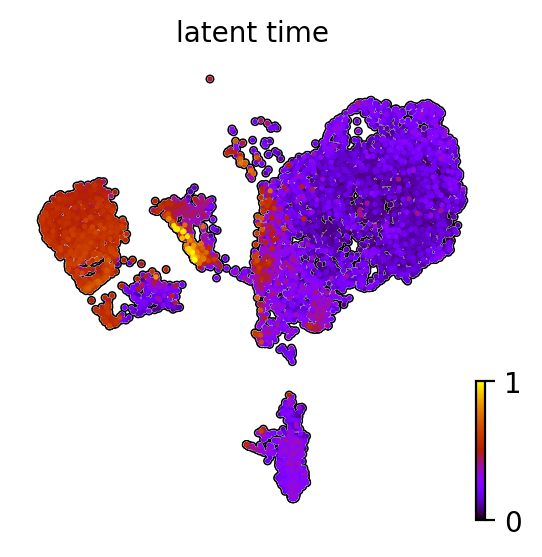

In [23]:
scv.tl.latent_time(adata)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 3

scv.pl.scatter(
    adata, 
    color='latent_time',
    color_map='gnuplot',
    add_outline=True,
)


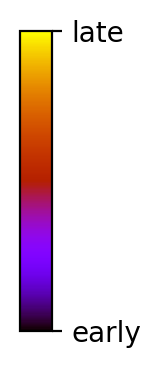

In [27]:
plt2.make_colorbar(cmap='gnuplot', tick_labels=['early', 'late'])

Text(0.5, 0, '')

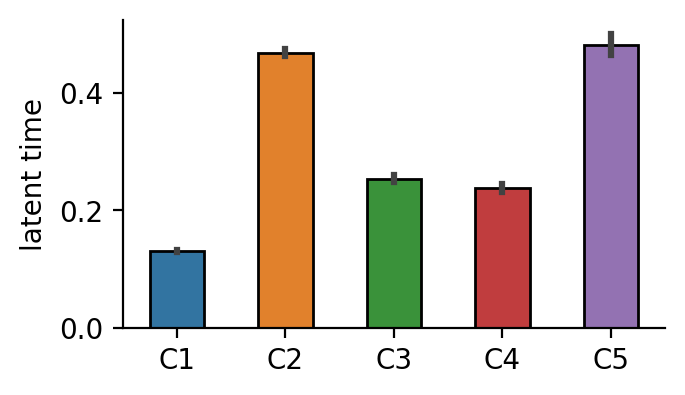

In [15]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3.5, 2

sns.barplot(
    data=adata.obs,
    x='cluster_str',
    y='latent_time',
    hue='cluster_str',
    width=0.5,
    ec='k',
)

sns.despine()

plt.ylabel('latent time')
plt.xlabel('')

Text(0, 0.5, '')

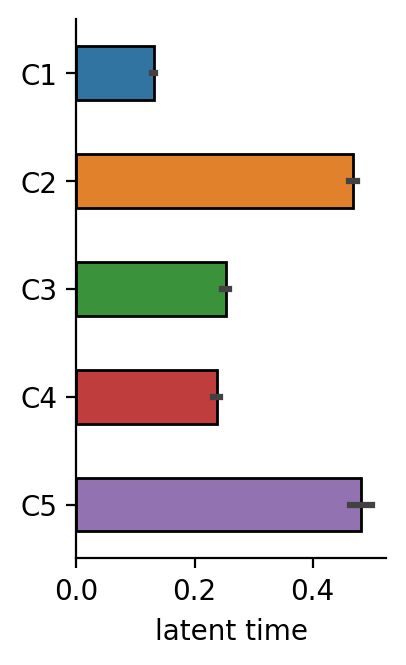

In [56]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 2, 3.5

sns.barplot(
    data=adata.obs,
    y='cluster_str',
    x='latent_time',
    hue='cluster_str',
    width=0.5,
    ec='k',
)

sns.despine()

plt.xlabel('latent time')
plt.ylabel('')

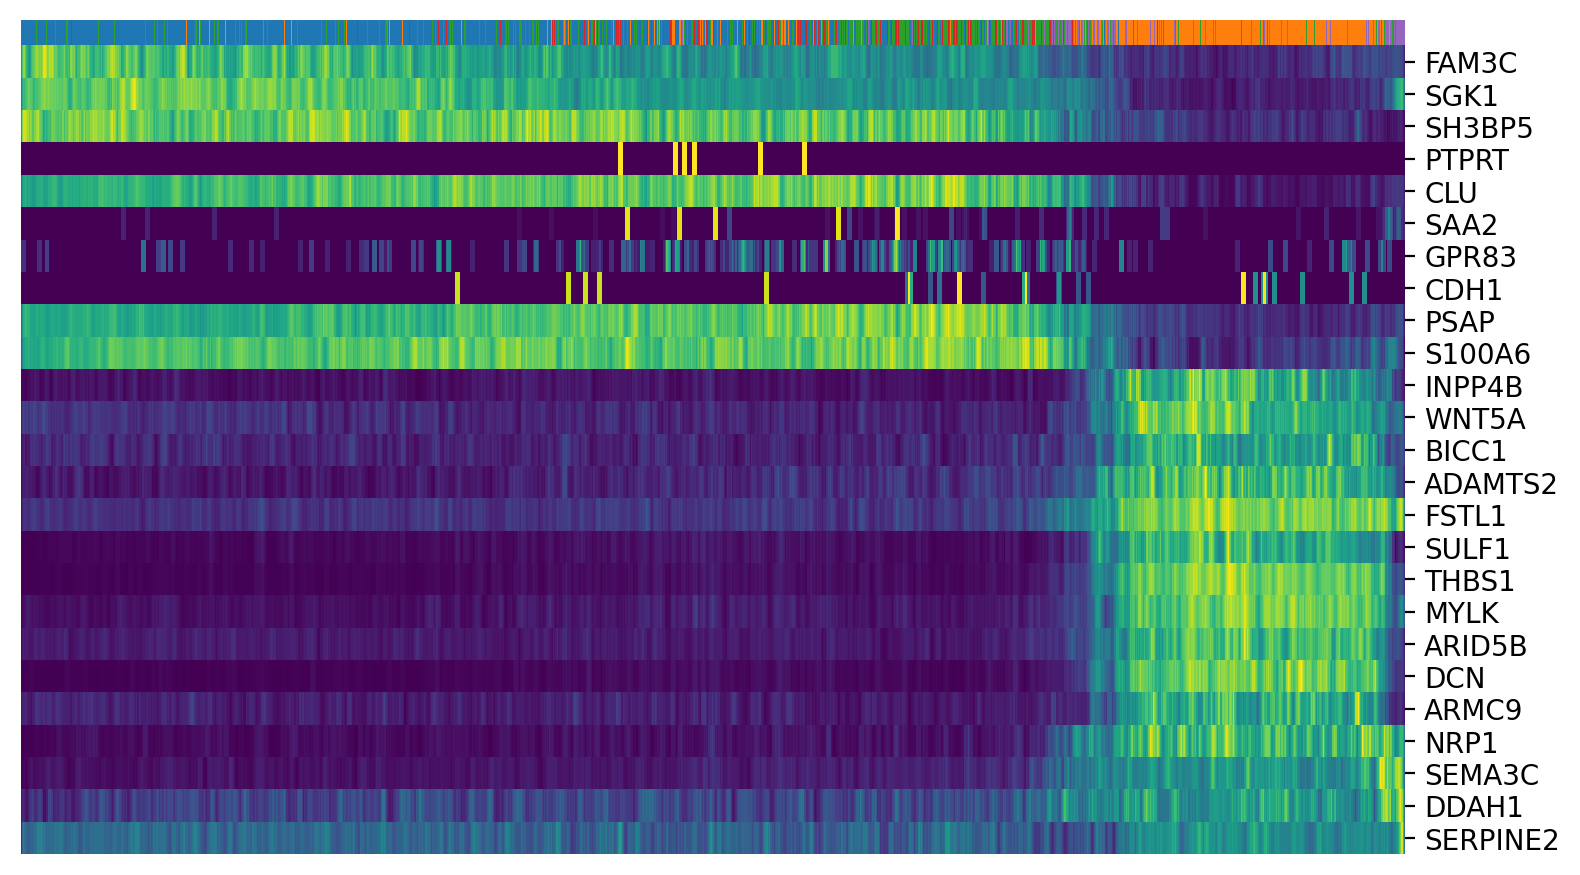

In [38]:
n_genes = 25
count_thr = 500
top_genes = adata.var.sort_values(by='fit_likelihood', ascending=False)
top_genes = top_genes[top_genes['n_cells'] > count_thr]

top_genes = top_genes['gene_name'].values[:n_genes]

plt.rcParams['figure.dpi'] = 200

scv.pl.heatmap(
    adata, 
    var_names=top_genes, 
    sortby='latent_time', 
    col_color='cluster_str', 
    figsize=(8, 4.5),
    yticklabels=True,
    n_convolve=30,
)

In [59]:
database = 'ontology'
n_genes = 50
top_genes = adata.var['fit_likelihood'].sort_values(ascending=False).index[:n_genes]
top_genes = list(top_genes)

edf = gget.enrichr(top_genes, database=database)
pd.set_option('display.max_colwidth', 100) 
edf[['path_name', 'adj_p_val', 'overlapping_genes']].head(15)

Mon Oct 28 14:40:17 2024 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    


,path_name,adj_p_val,overlapping_genes
0,extracellular matrix organization (GO:0030198),0.000003,"[GREM1, ADAMTS2, GSN, CDH1, COL6A2, TNC, COL6A3, THBS1, FGF2, DCN]"
1,regulation of cell migration (GO:0030334),0.000014,"[PTPRT, SEMA5A, SERPINE2, SEMA3C, CDH1, SGK1, SULF1, THBS1, FGF2, MYLK]"
2,extracellular structure organization (GO:0043062),0.000014,"[ADAMTS2, CDH1, COL6A2, TNC, COL6A3, THBS1, FGF2, DCN]"
3,external encapsulating structure organization (GO:0045229),0.000014,"[ADAMTS2, CDH1, COL6A2, TNC, COL6A3, THBS1, FGF2, DCN]"
4,regulation of endothelial cell proliferation (GO:0001936),0.000020,"[SEMA5A, NRP1, WNT5A, SULF1, THBS1, FGF2]"
5,sprouting angiogenesis (GO:0002040),0.000029,"[SEMA5A, GREM1, NRP1, THBS1, FGF2]"
6,positive regulation of endothelial cell migration (GO:0010595),0.000315,"[SEMA5A, NRP1, WNT5A, THBS1, FGF2]"
7,regulation of endothelial cell migration (GO:0010594),0.000327,"[NRP1, WNT5A, THBS1, FGF2, DCN]"
8,regulation of plasminogen activation (GO:0010755),0.000328,"[SERPINE2, ENO1, THBS1]"
9,positive regulation of chemotaxis (GO:0050921),0.000443,"[SEMA5A, NRP1, FGF2, THBS1]"


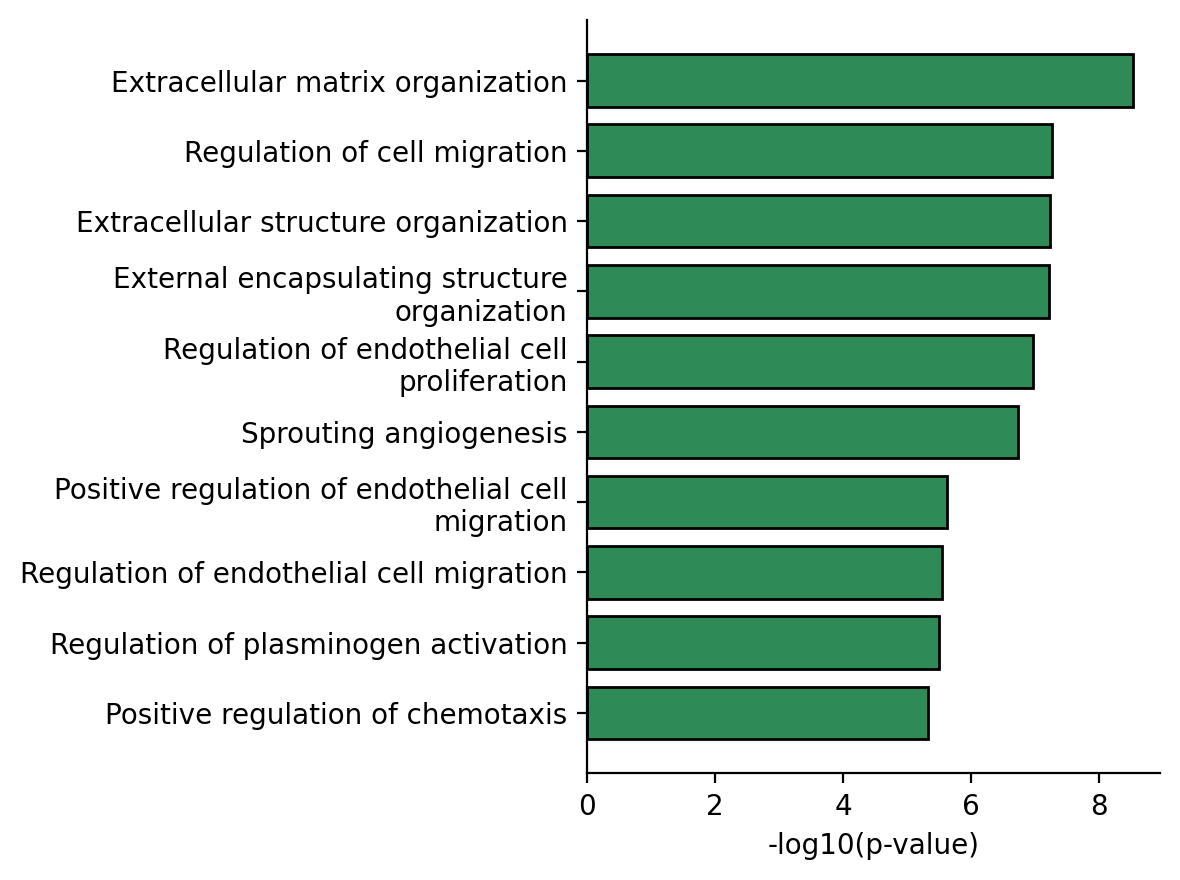

In [55]:
def plot_pathway_enrichment(df):
    """
    Plots pathway enrichment results from a DataFrame.

    Args:
        df: DataFrame containing 'path_name' and 'p_val' columns.
    """
    
    # Sort and calculate -log10(p_val)
    df_sorted = df.sort_values('p_val')
    df_sorted['neg_log10_pval'] = -np.log10(df_sorted['p_val'])
    df_sorted['pname'] = df_sorted['path_name'].apply(lambda x: x.split("(")[0].capitalize())
    
    wrapped_labels = [fill(label, 40) for label in df_sorted['pname']]

    # Create the plot
    plt.barh(
        wrapped_labels, 
        df_sorted['neg_log10_pval'], 
        color='seagreen',
        height=0.75,
        ec='k',
    )

    # Set labels and title
    plt.xlabel('-log10(p-value)')

    # Invert y-axis and set x-axis ticks/limits
    plt.gca().invert_yaxis() 
    sns.despine()

    # Show the plot
    plt.tight_layout()


plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 4.5
plot_pathway_enrichment(edf.head(10))

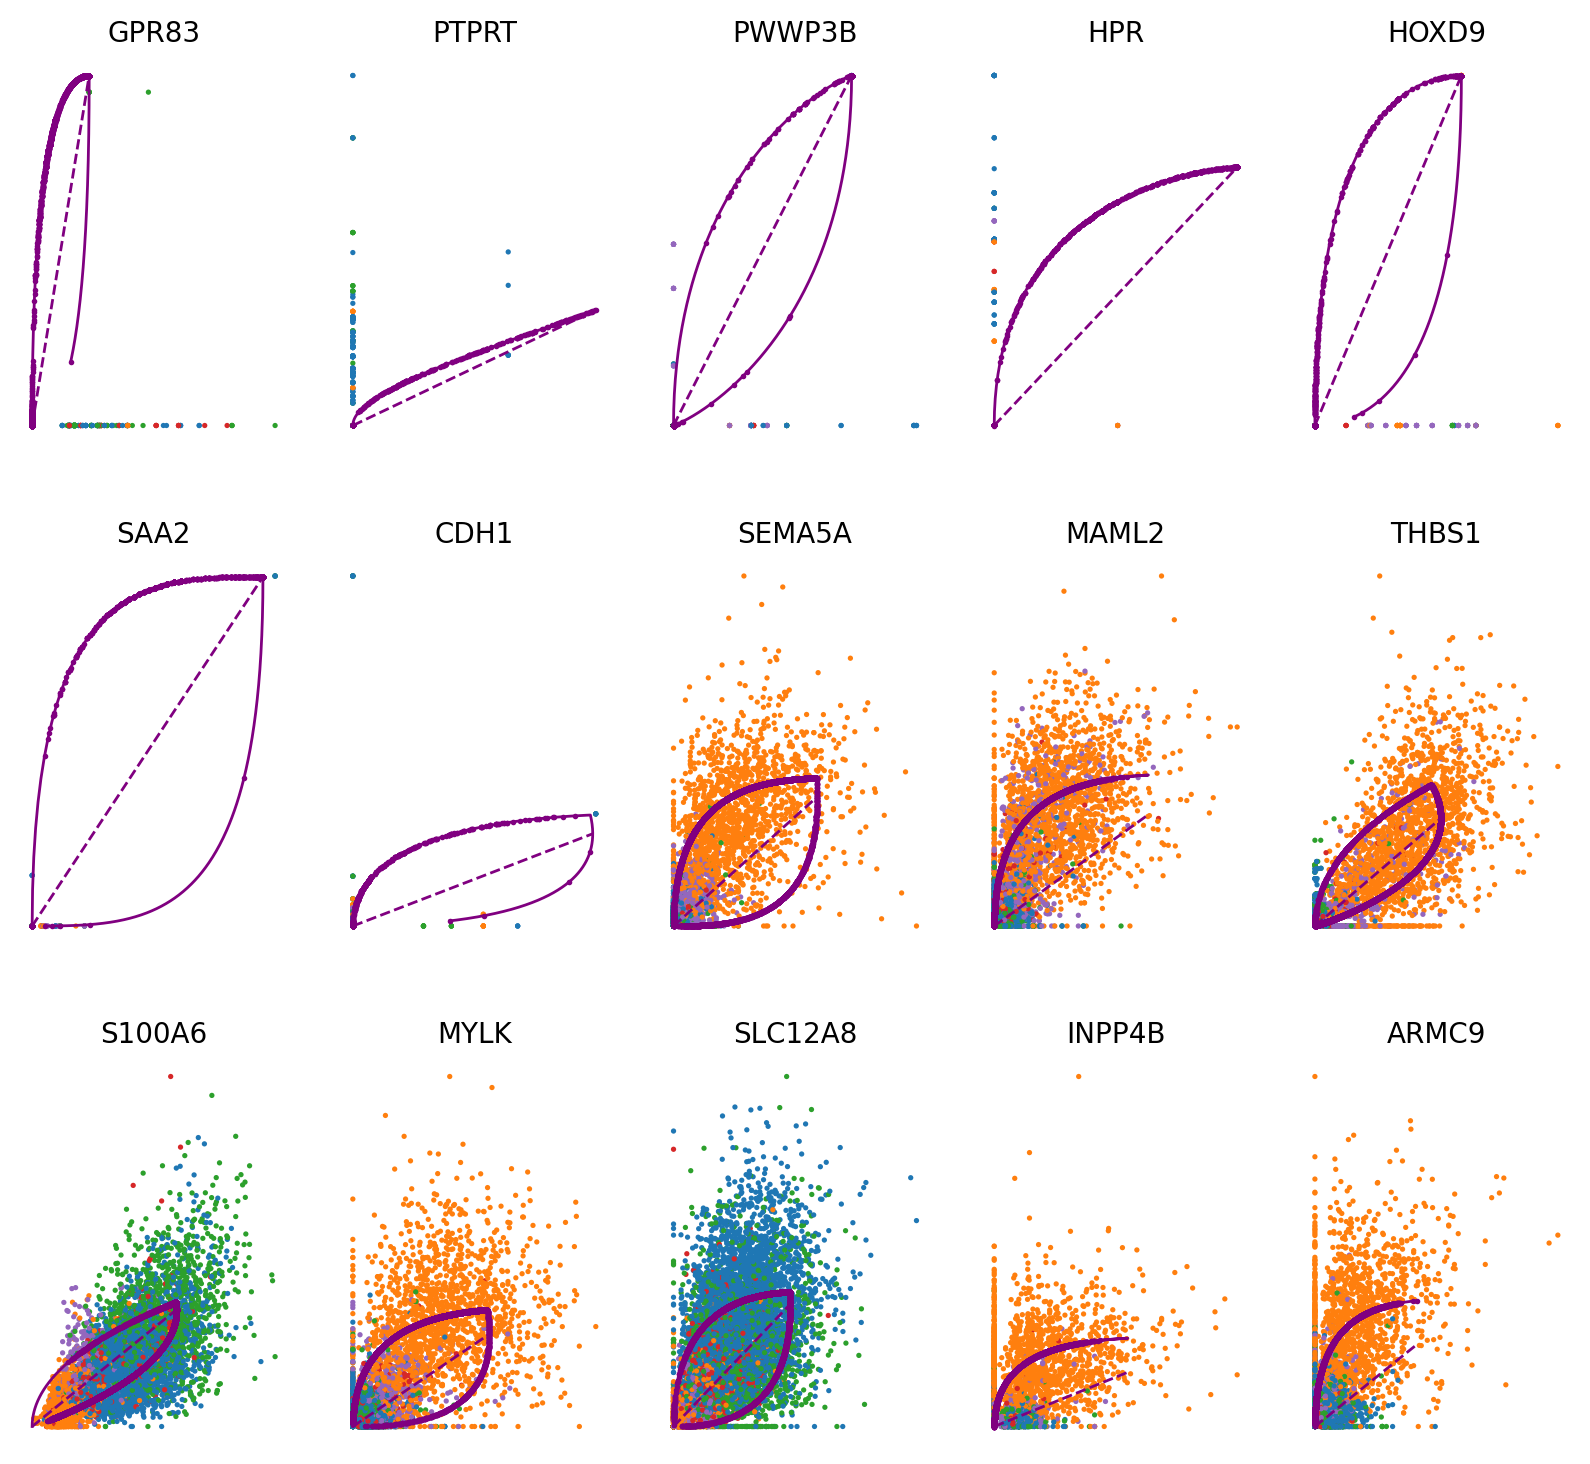

In [18]:
n_genes = 15
top_genes = adata.var['fit_likelihood'].sort_values(ascending=False).index

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 2, 3

scv.pl.scatter(
    adata, 
    basis=top_genes[:n_genes], 
    color='cluster_str', 
    ncols=5, 
    frameon=False,
)

# Gene Ranking

In [19]:
scv.tl.rank_dynamical_genes(adata, groupby='cluster_str')

df = scv.get_df(adata, 'rank_dynamical_genes/names')
df.head()

ranking genes by cluster-specific likelihoods
    finished (0:00:01) --> added 
    'rank_dynamical_genes', sorted scores by group ids (adata.uns)


,C1,C2,C3,C4,C5
0,S100A6,SEMA5A,SLC12A8,SLC12A8,MAML2
1,SLC12A8,THBS1,S100A6,TPX2,THBS1
2,ENO1,MAML2,GSN,CDK1,S100A6
3,GSN,MYLK,SH3BP5,CENPE,ENO1
4,S100A10,RBPMS,ENO1,MKI67,GREM1


In [20]:
database = 'ontology'
n_genes = 25
cluster = 'C2'
top_genes = df[cluster].head(n_genes)
top_genes = list(top_genes)

edf = gget.enrichr(top_genes, database=database)
pd.set_option('display.max_colwidth', 100) 
edf[['path_name', 'adj_p_val', 'overlapping_genes']].head(15)

Mon Oct 28 11:38:37 2024 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    


,path_name,adj_p_val,overlapping_genes
0,extracellular matrix organization (GO:0030198),2.938385e-08,"[GREM1, ADAMTS2, ADAMTS1, TNC, COL8A1, COL6A3, THBS1, FGF2, DCN]"
1,extracellular structure organization (GO:0043062),2.938385e-08,"[ADAMTS2, ADAMTS1, TNC, COL8A1, COL6A3, THBS1, FGF2, DCN]"
2,external encapsulating structure organization (GO:0045229),2.938385e-08,"[ADAMTS2, ADAMTS1, TNC, COL8A1, COL6A3, THBS1, FGF2, DCN]"
3,sprouting angiogenesis (GO:0002040),7.047573e-07,"[GREM1, SEMA5A, NRP1, THBS1, FGF2]"
4,regulation of endothelial cell proliferation (GO:0001936),1.031834e-05,"[SEMA5A, NRP1, SULF1, THBS1, FGF2]"
5,regulation of angiogenesis (GO:0045765),1.444346e-05,"[SEMA5A, ADAMTS1, SULF1, THBS1, FGF2, DCN]"
6,positive regulation of chemotaxis (GO:0050921),2.208952e-05,"[SEMA5A, NRP1, THBS1, FGF2]"
7,regulation of cell migration (GO:0030334),3.458030e-05,"[SEMA5A, SEMA3C, SERPINE2, SULF1, THBS1, FGF2, MYLK]"
8,negative regulation of fibroblast growth factor receptor signaling pathway (GO:0040037),3.913308e-05,"[SULF1, FGF2, THBS1]"
9,regulation of endothelial cell chemotaxis (GO:2001026),4.398852e-05,"[SEMA5A, FGF2, THBS1]"


In [21]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

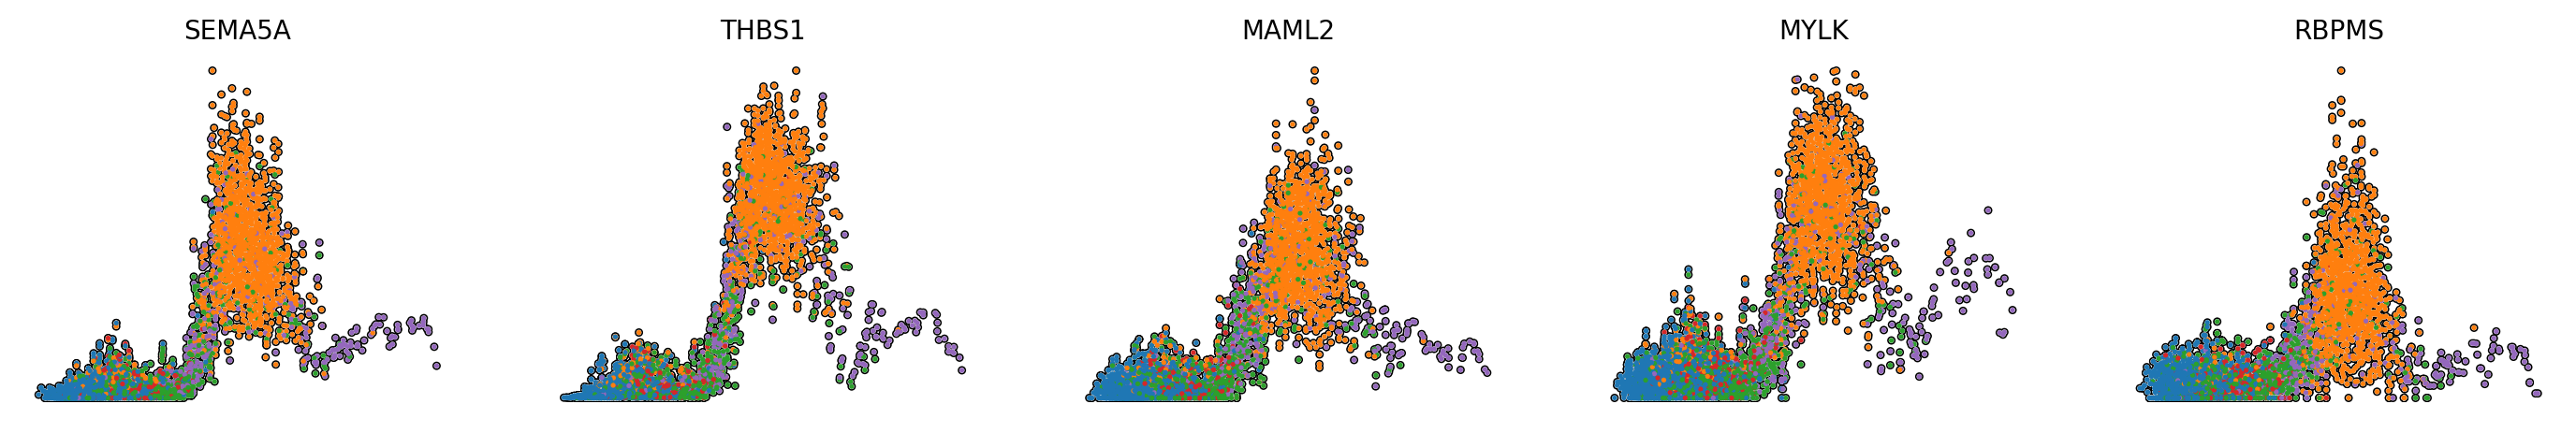

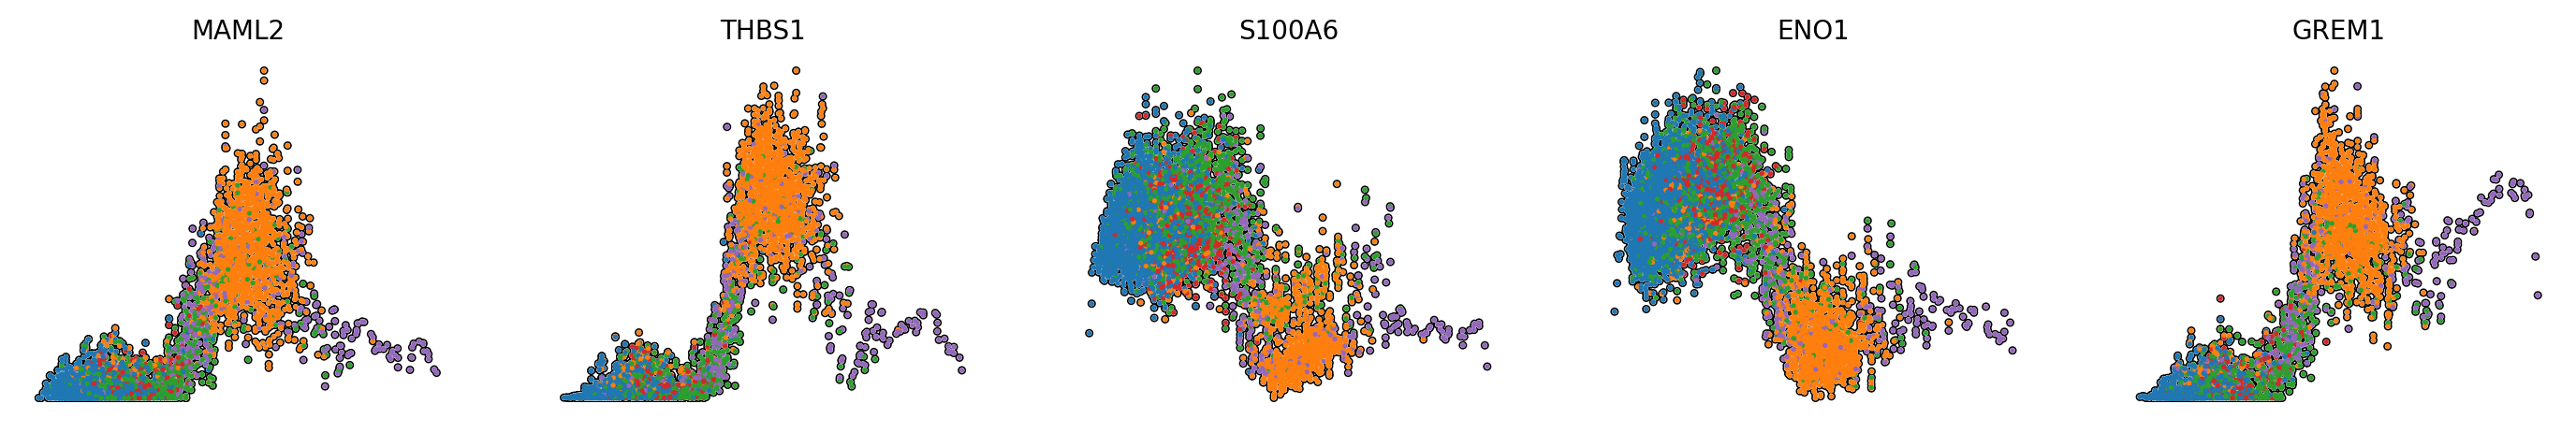

In [72]:
n_genes = 5

for cluster in ['C2', 'C5']:

    plt.rcParams['figure.dpi'] = 200
    plt.rcParams['figure.figsize'] = 3.5, 2.5

    gene_list = list(df[cluster].head(n_genes))

    scv.pl.scatter(
        adata, 
        x='latent_time', 
        y=gene_list,
        color='cluster_str',
        frameon=False,
        smooth=15,
        dpi=200,
        add_outline=True,
        n_convolve=5,
    )
    plt.show()